## Importando as bibliotecas necessarias:

In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/felipe/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funcao para visualizar imagens a partir dos tensores e configuracoes iniciais:

Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


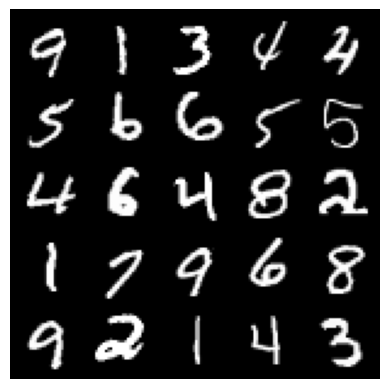

In [2]:
def show_tensor_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.axis('off')
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

# More transforms can be added
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    MNIST('data/', download=True, transform=transform),
    batch_size=128,
    shuffle=True)

# Display images from train_loader
dataiter = iter(train_loader)
images,labels = next(dataiter)
print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

show_tensor_images(images)



## Declarando o Gerador e o Discriminador:

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True),
        )

    def gen_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, x):
        x = x.view(len(x), self.z_dim, 1, 1) #change the shape: (batch_size, channels=z_dim, width=1, height=1)
        return self.gen(x)
    
class Discriminator(nn.Module):
    def __init__(self, img_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim, kernel_size=4),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=1),
            self.disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def disc_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride)
            )
  
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1) # returns 1-dimension tensor representing fake/real

## Hiperparametros, Otimizador e Funcao de perda:

In [4]:
display_step = 1000

epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
batch_size = 128

z_dim = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G = Generator(z_dim).to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

G = G.apply(weights_init)
D = D.apply(weights_init)

beta_1 = 0.5 # parameters control the optimizer's momentum
beta_2 = 0.999 # parameters control the optimizer's momentum

G_opt = torch.optim.Adam(G.parameters(),lr=0.0002, betas=(beta_1, beta_2))
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(beta_1, beta_2))

# 'BinaryCrossEntropy Loss' is used to evaluate how well dicriminator and generator performs
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.zeros_like(disc_pred))
    return loss

## Treinamento:

 13%|█▎        | 60/469 [00:01<00:09, 45.43it/s]

Step 1000: Generator loss: 2.2258318918347357, discriminator loss: 0.22530362051352848


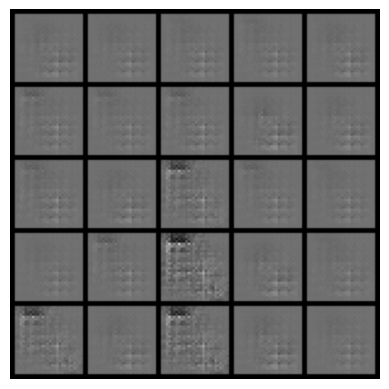

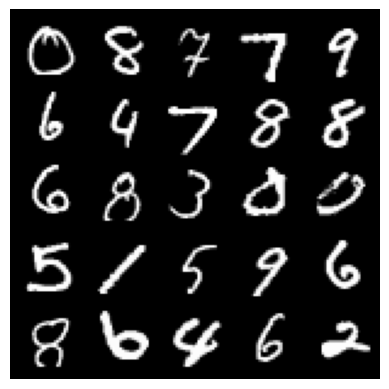

 26%|██▌       | 120/469 [00:02<00:07, 45.91it/s]

Step 2000: Generator loss: 2.3460964305996894, discriminator loss: 0.3326290547009555


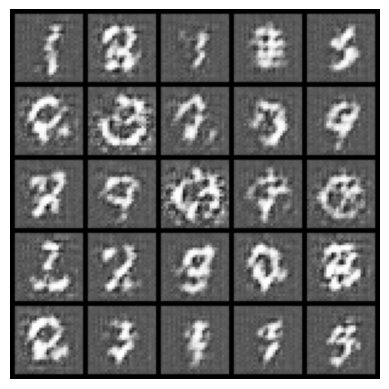

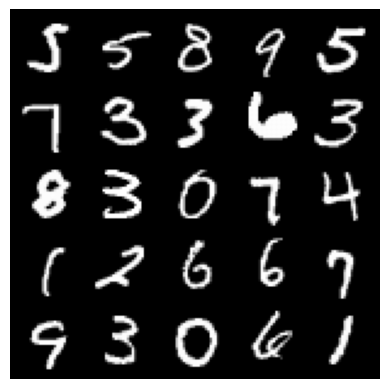

 39%|███▉      | 185/469 [00:04<00:06, 45.54it/s]

Step 3000: Generator loss: 1.4537480855211604, discriminator loss: 0.43274219940602743


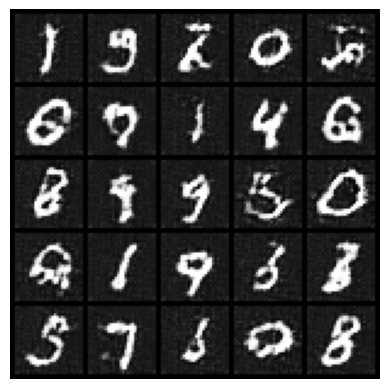

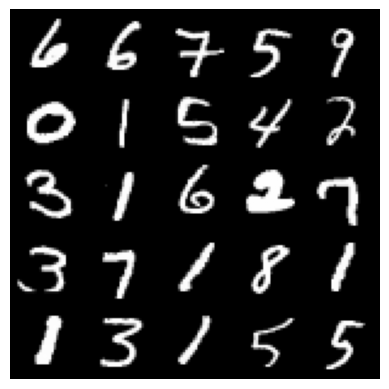

 52%|█████▏    | 245/469 [00:05<00:04, 46.70it/s]

Step 4000: Generator loss: 1.1584869763255128, discriminator loss: 0.48837936002016047


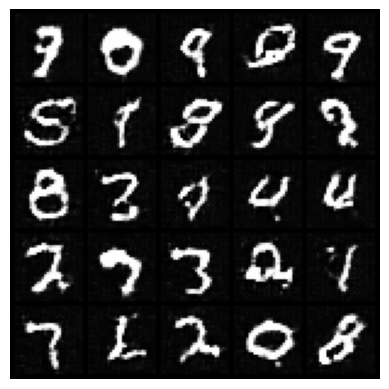

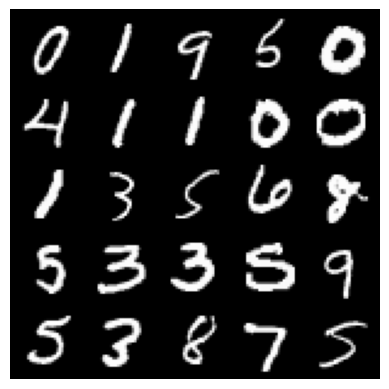

 66%|██████▌   | 310/469 [00:06<00:03, 46.22it/s]

Step 5000: Generator loss: 1.115695620089768, discriminator loss: 0.5046584071218975


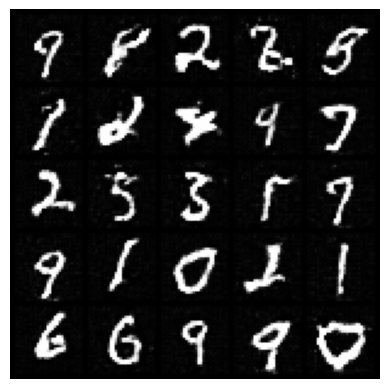

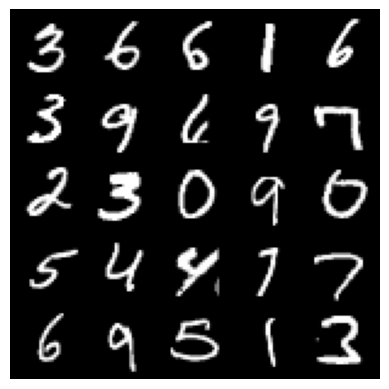

 79%|███████▉  | 370/469 [00:08<00:02, 45.21it/s]

Step 6000: Generator loss: 1.1457593794018022, discriminator loss: 0.497698484271765


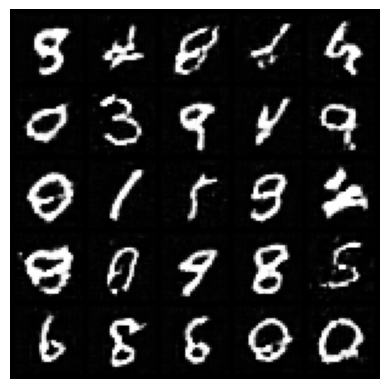

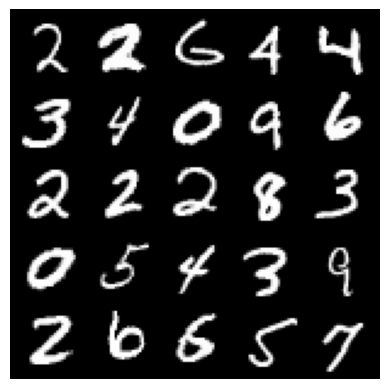

 92%|█████████▏| 430/469 [00:09<00:00, 46.26it/s]

Step 7000: Generator loss: 1.139478303402663, discriminator loss: 0.49886197027564055


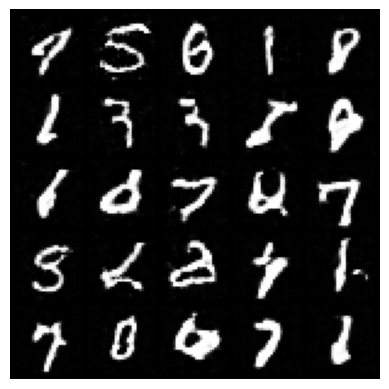

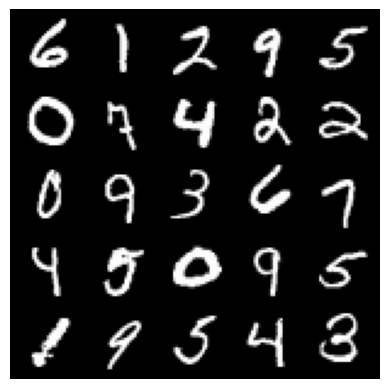

  5%|▌         | 25/469 [00:00<00:09, 46.03it/s]

Step 8000: Generator loss: 1.131052213430403, discriminator loss: 0.5098037087917328


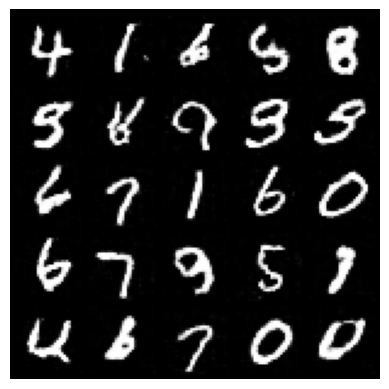

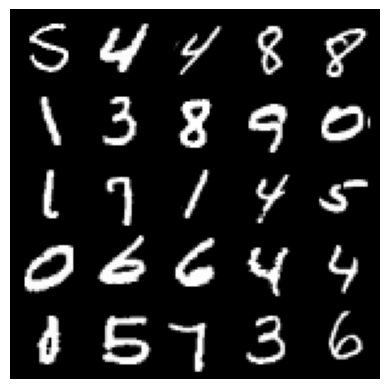

 18%|█▊        | 85/469 [00:01<00:08, 46.60it/s]

Step 9000: Generator loss: 1.0980103017091762, discriminator loss: 0.5210276568531995


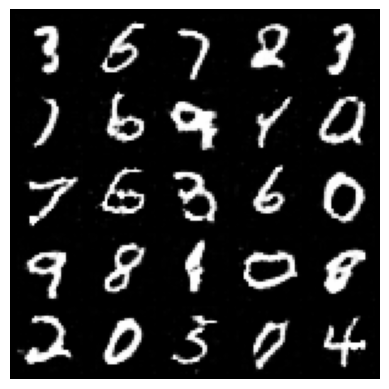

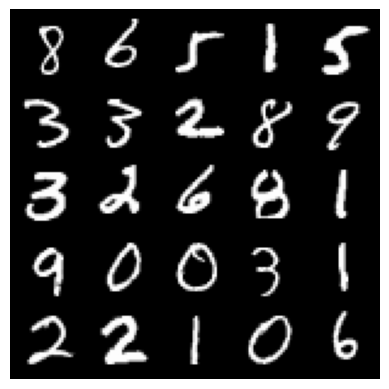

 32%|███▏      | 150/469 [00:03<00:06, 45.73it/s]

Step 10000: Generator loss: 1.0670195005834113, discriminator loss: 0.5382197681665418


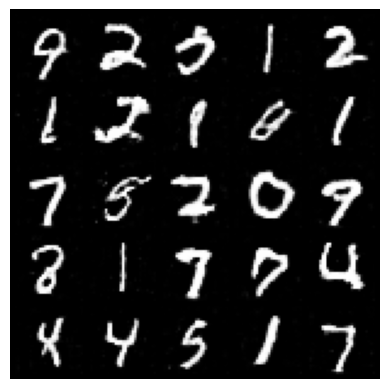

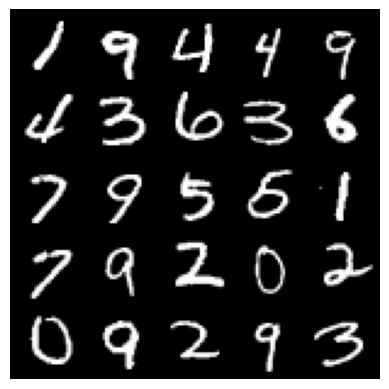

 45%|████▍     | 210/469 [00:04<00:05, 46.38it/s]

Step 11000: Generator loss: 1.0503456967920062, discriminator loss: 0.5505034231841565


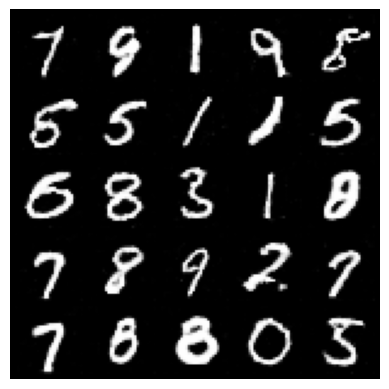

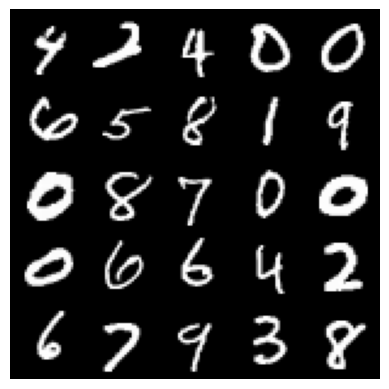

 59%|█████▊    | 275/469 [00:06<00:04, 45.61it/s]

Step 12000: Generator loss: 1.0334024209082107, discriminator loss: 0.5592825769484042


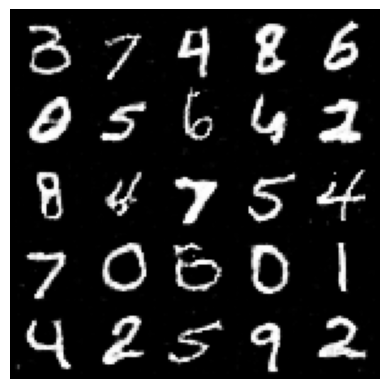

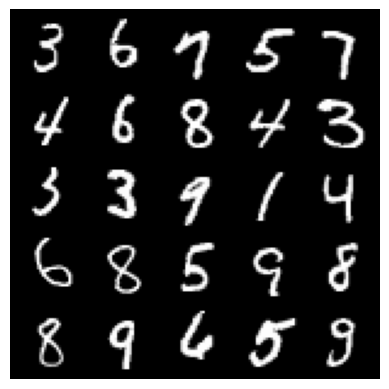

 71%|███████▏  | 335/469 [00:07<00:02, 46.05it/s]

Step 13000: Generator loss: 1.0085264078080645, discriminator loss: 0.5718018884658802


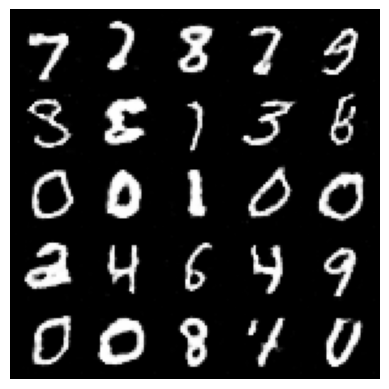

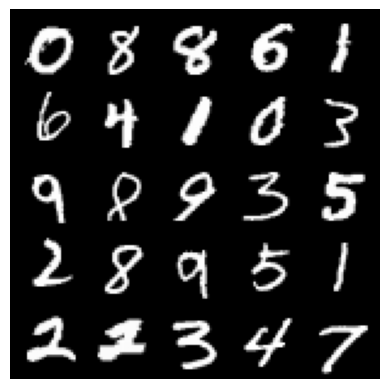

 84%|████████▍ | 395/469 [00:08<00:01, 46.27it/s]

Step 14000: Generator loss: 0.9928082367181783, discriminator loss: 0.5808918562531472


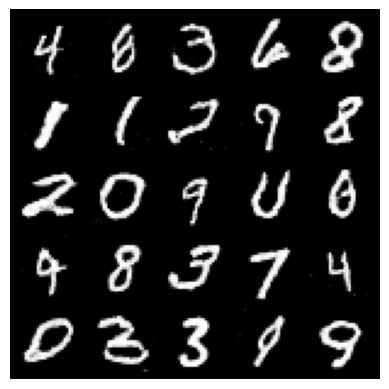

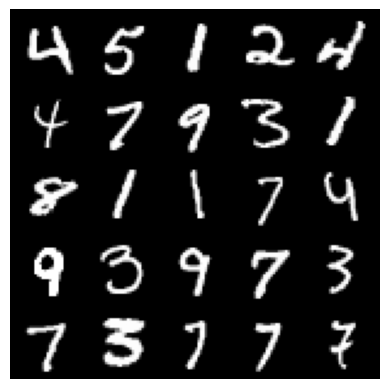

 98%|█████████▊| 460/469 [00:09<00:00, 47.11it/s]

Step 15000: Generator loss: 0.9715335834920421, discriminator loss: 0.5917306343615043


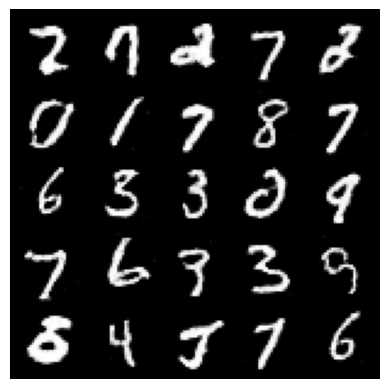

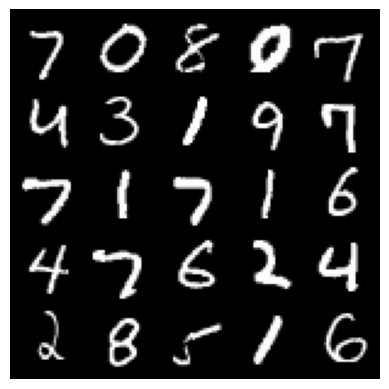

 11%|█         | 50/469 [00:01<00:08, 47.73it/s]

Step 16000: Generator loss: 0.9545210878998037, discriminator loss: 0.5981038519740107


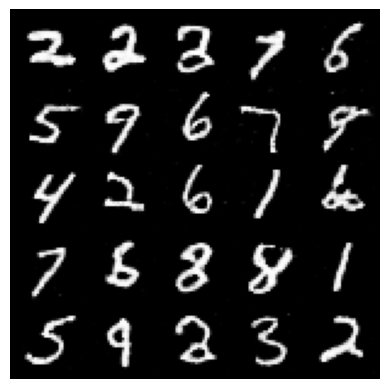

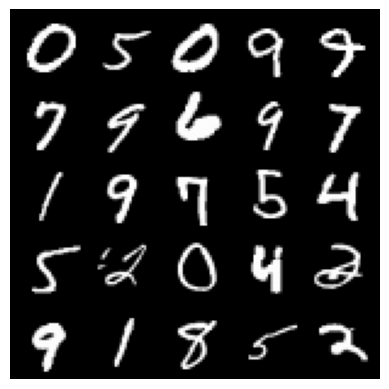

 25%|██▍       | 115/469 [00:02<00:07, 47.80it/s]

Step 17000: Generator loss: 0.9472507931292078, discriminator loss: 0.6010598886609073


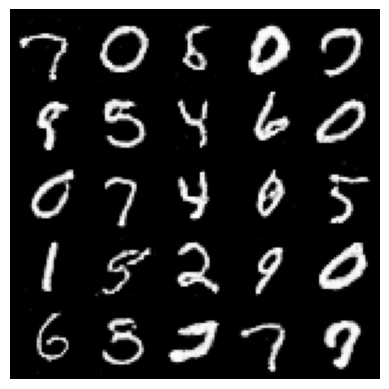

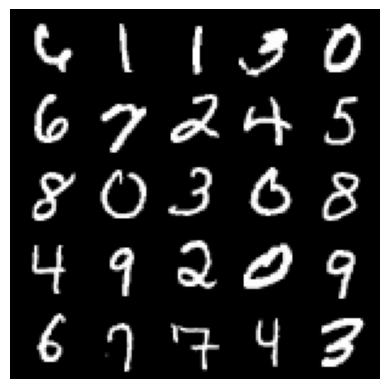

 37%|███▋      | 175/469 [00:03<00:06, 48.81it/s]

Step 18000: Generator loss: 0.9376441944986581, discriminator loss: 0.6066187439560887


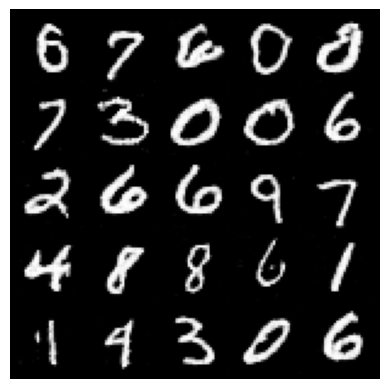

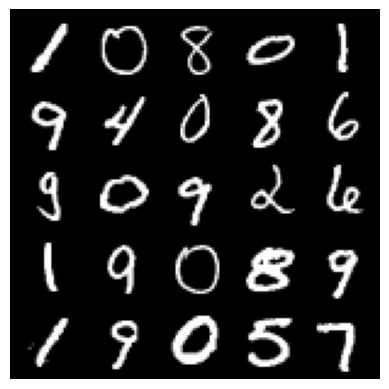

 51%|█████     | 240/469 [00:04<00:04, 47.85it/s]

Step 19000: Generator loss: 0.9266356417685742, discriminator loss: 0.6102356528639782


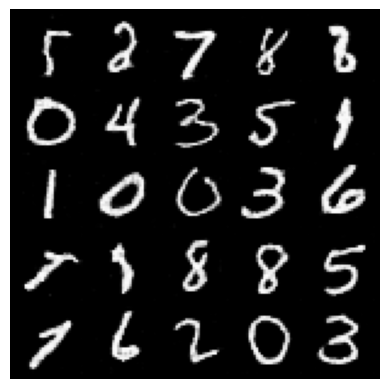

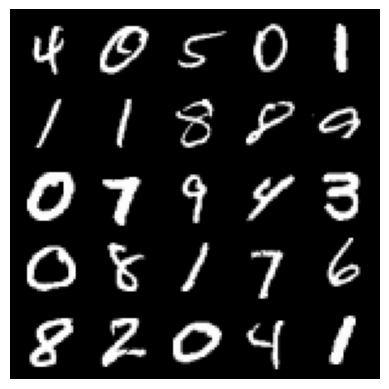

 64%|██████▍   | 300/469 [00:06<00:03, 48.54it/s]

Step 20000: Generator loss: 0.9216907283365721, discriminator loss: 0.61432281523943


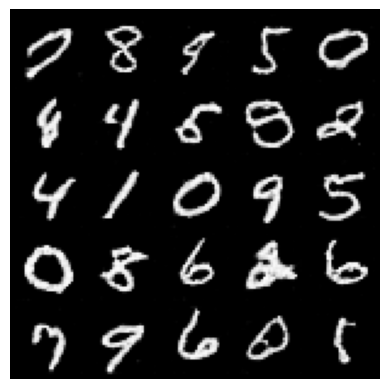

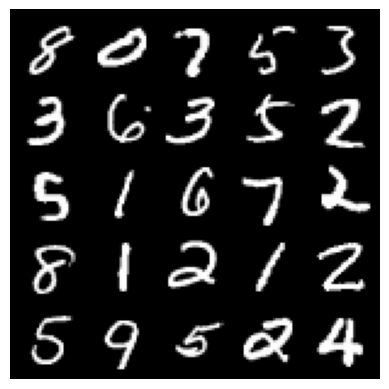

 77%|███████▋  | 360/469 [00:07<00:02, 48.01it/s]

Step 21000: Generator loss: 0.9106833803057666, discriminator loss: 0.61906951969862


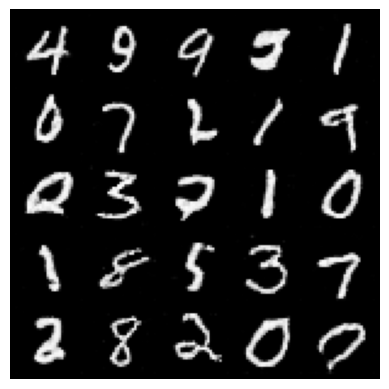

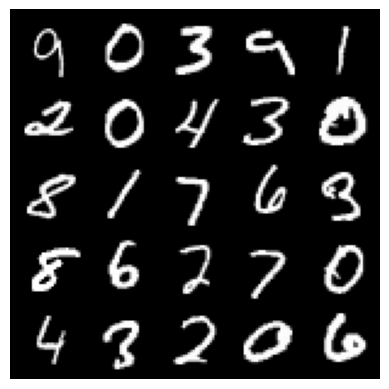

 91%|█████████ | 425/469 [00:08<00:00, 47.60it/s]

Step 22000: Generator loss: 0.9059720841944221, discriminator loss: 0.6201341208219524


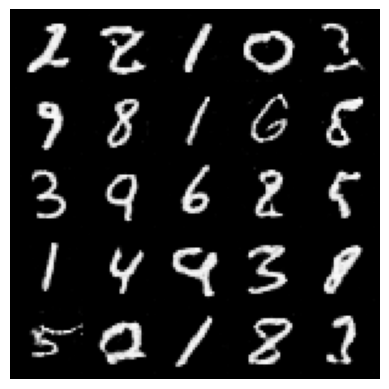

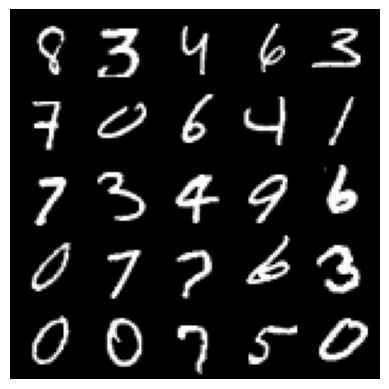

  3%|▎         | 15/469 [00:00<00:09, 47.99it/s]

Step 23000: Generator loss: 0.8957096039354803, discriminator loss: 0.6242140703797343


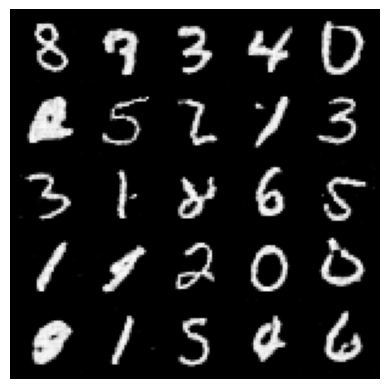

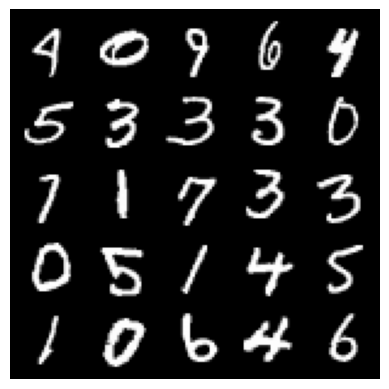

100%|██████████| 469/469 [00:09<00:00, 47.63it/s]


In [10]:
for epoch in range(epochs):
    for real_img,_ in tqdm(train_loader):

        batch_size = real_img.size(0)
        real_img = real_img.to(device)

        #  Update Discriminator  #
        D_opt.zero_grad()

        noise = torch.randn(batch_size, z_dim, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img.detach())
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)
        D_loss = (D_fake_loss + D_real_loss) / 2
        mean_discriminator_loss += D_loss.item() / display_step    # Keep track of the average discriminator loss

        D_loss.backward(retain_graph=True)
        D_opt.step()

        # Update Generator #
        G_opt.zero_grad()
        noise = torch.randn(batch_size, z_dim, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)
        mean_generator_loss += G_loss.item() / display_step     # Keep track of the average generator loss

        G_loss.backward()
        G_opt.step()

        # Visualization #
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake_img)
            show_tensor_images(real_img)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

    torch.save(G.state_dict(), f'./epochs_gan_conv/g/g_epoch_{epoch + 1}.pth')
    torch.save(D.state_dict(), f'./epochs_gan_conv/d/d_epoch_{epoch + 1}.pth')

## Salvando resultados:

In [ ]:
for i in range(0, 1000):
    noise = torch.randn(batch_size, z_dim, device=device)
    sample = G(noise)
    tensor_img = (sample + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:1], nrow=5)
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.savefig(f"images_convgan/image_convgan{i}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

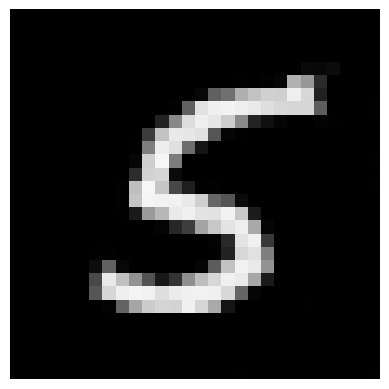

In [21]:

noise = torch.randn(batch_size, z_dim, device=device)
sample = G(noise)

show_tensor_images(sample, num_img=1)